# A project of Matteo Conterno, Rodolfo Petrelli, Filippo Scaramozzino, Filippo Orlandi and Matteo Ling

We develop a volatility surface from a given set of call options data and check for arbitrage opportunities within the dataset. We analyze how option prices react to changes in implied volatility using Vega, Vanna and Volga (VVV) components, and test P&L performance on the exploited arbitrage opportunities.

### Importing Libraries

In [ ]:
!pip install QuantLib

In [5]:
import numpy as np
import pandas as pd
import QuantLib as ql
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.interpolate import interp1d
from plotly.subplots import make_subplots

### Preprocess the dataset

Convert the entire excel sheet in a single dataframe in order to have a single variable considering everything and normalize the days by calculating the maturities in a year.

In [ ]:
path = r"SPX.xlsx"
dodf = pd.read_excel(path, sheet_name=None)
df = pd.merge(dodf.get("IVS"),
              dodf.get("Fwd"),
              how="left",
              on=["Date", "Days"]
              )
df["Maturity"] = df["Days"] / 365
display(df)

,Date,Days,Delta,Volatility,Strike,Forward,Spot,Maturity
0,2000-01-03,30,0.1,0.172792,1558.999,1461.336754,1458.18,0.082192
1,2000-01-03,91,0.1,0.173377,1653.449,1474.440355,1458.18,0.249315
2,2000-01-03,182,0.1,0.165017,1746.986,1494.896179,1458.18,0.498630
3,2000-01-03,273,0.1,0.162485,1832.825,1516.515312,1458.18,0.747945
4,2000-01-03,365,0.1,0.162835,1920.602,1539.565658,1458.18,1.000000
...,...,...,...,...,...,...,...,...
138395,2021-12-31,30,0.9,0.297709,4283.507,4763.391298,4776.29,0.082192
138396,2021-12-31,91,0.9,0.300537,3960.417,4757.947241,4776.29,0.249315
138397,2021-12-31,182,0.9,0.312074,3643.571,4750.604483,4776.29,0.498630
138398,2021-12-31,273,0.9,0.332495,3372.290,4744.505281,4776.29,0.747945


### Plot the implied volatility surface

The order under which the intepolation is done matters in many case, in our code we decided to intepolate:

1.   Over the strikes to present the volatility smile
2.   Over the maturity to add the possible missing point

In case of interpolation we have decided to use linear and quadratic, the second one is done to obtain a smooth surface.

In [10]:
def quad_interpolate_pivot(pivot):
    """
    Perform quadratic interpolation on a pivot table using only existing points
    """
    result = pivot.copy()

    # First interpolate along strikes (index)
    for col in result.columns:
        valid = result[col].dropna()
        if len(valid) >= 3:
            quad_interp = interp1d(valid.index,
                                 valid.values,
                                 kind='quadratic',
                                 bounds_error=False)
            result[col] = quad_interp(result.index)

    # Then interpolate along maturities (columns)
    for idx in result.index:
        row = result.loc[idx].dropna()
        if len(row) >= 3:
            quad_interp = interp1d(row.index,
                                 row.values,
                                 kind='quadratic',
                                 bounds_error=False)
            result.loc[idx] = quad_interp(result.columns)

    return result

In [11]:
# Select a specific date for plotting (e.g., latest available)
selected_date = df["Date"].max()
df_filtered = df[df["Date"] == selected_date]

# Create pivot table
pivot_table = df_filtered.pivot_table(
    values='Volatility',
    index='Strike',
    columns='Maturity',
    aggfunc='last'
)

# Interpolate missing values using linear interpolation
linear_pivot_table = pivot_table.interpolate(method='linear', axis=0)
linear_pivot_table = linear_pivot_table.interpolate(method='linear', axis=1)
linear_pivot_table = linear_pivot_table.ffill().bfill()

X, Y = np.meshgrid(linear_pivot_table.columns, linear_pivot_table.index)
Z = linear_pivot_table.values

quadratic_pivot_table = quad_interpolate_pivot(pivot_table)
Xq, Yq = np.meshgrid(quadratic_pivot_table.columns, quadratic_pivot_table.index)
Zq = quadratic_pivot_table.values

# Create a Plotly 3D surface plot
fig = make_subplots(rows=1, cols=2,
                    specs=[[{'is_3d': True}, {'is_3d': True}]],
                    subplot_titles=['Linear',
                                    'Quadratic',
                                    'Cubic'],
                    )

fig.add_trace(go.Surface(
        z=Z,
        x=X,
        y=Y,
        colorscale='Viridis',
        colorbar=dict(title="Implied Volatility")
    ), row=1, col=1)

fig.add_trace(go.Surface(
        z=Zq,
        x=Xq,
        y=Yq,
        colorscale='Viridis',
        colorbar=dict(title="Implied Volatility")
    ), row=1, col=2)

scene = dict(
  xaxis=dict(
      title=dict(
          text='Maturities'
      )
  ),
  yaxis=dict(
      title=dict(
          text='Strikes'
      )
  ),
  zaxis=dict(
      title=dict(
          text='Volatilities'
      )
  ),
)

fig.update_layout(
    title=f"Implied Volatility Surface Interpolation on {selected_date}",
    title_x=0.5,
    title_y=0.95
)

fig.update_layout(
    scene = scene,
    scene2 = scene
)

fig.show()


## Calculate the Vanna Vega Volga sensitivities

To calculate the sensitivities of the call options we decided to use an engine called quantlib in order to handle the heavyweight calculation required and reduce the time. We decide to give an average estimate of this quantity by applying a small volatility shock of $\pm 1%$.

We know that the average of non-linearity quantity is not correct since we should consider a weighted qunatity, but this was done only to obtain an estimate, since no arbitrage opportunities have been found capable of leveraging these quantities.

In [12]:
class GreeksCalculator:
    def __init__(self, settlement_date, rate=0.02, day_count=ql.Actual365Fixed()):
        self.settlement_date = settlement_date
        self.day_count = day_count
        self.calendar = ql.NullCalendar()
        self.yield_curve = ql.FlatForward(
            settlement_date,
            ql.QuoteHandle(ql.SimpleQuote(rate)),
            day_count
        )
        self.yield_curve_handle = ql.YieldTermStructureHandle(self.yield_curve)
        self.epsilon = 1e-4

    def create_process(self, S, sigma):
        """Create a Black-Scholes process with given spot and volatility"""
        vol_ts = ql.BlackConstantVol(
            self.settlement_date,
            self.calendar,
            ql.QuoteHandle(ql.SimpleQuote(sigma)),
            self.day_count
        )
        return ql.BlackScholesProcess(
            ql.QuoteHandle(ql.SimpleQuote(S)),
            self.yield_curve_handle,
            ql.BlackVolTermStructureHandle(vol_ts)
        )


    def create_option(self, K, T, option_type="call"):
        """Create a European option """
        maturity_date = self.settlement_date + int(T * 365)
        payoff = ql.PlainVanillaPayoff(
            ql.Option.Call if option_type == "call" else ql.Option.Put,
            K
        )
        return ql.EuropeanOption(
            payoff,
            ql.EuropeanExercise(maturity_date)
        )

    def compute_greeks(self, S, K, T, sigma, option_type="call"):
        """Compute all Greeks in a single pass"""
        shocks = np.array([-0.01, 0.01])

        vega_values, vanna_values, volga_values = [], [], []

        for shock in shocks:
            shocked_sigma = sigma * (1 + shock)

            process = self.create_process(S, shocked_sigma)
            option = self.create_option(K, T, option_type)
            option.setPricingEngine(ql.AnalyticEuropeanEngine(process))

            vega = option.vega()
            vega_values.append(vega)

            spot_up_process = self.create_process(S * (1 + self.epsilon), shocked_sigma)
            spot_down_process = self.create_process(S * (1 - self.epsilon), shocked_sigma)

            option.setPricingEngine(ql.AnalyticEuropeanEngine(spot_up_process))
            vega_up = option.vega()

            option.setPricingEngine(ql.AnalyticEuropeanEngine(spot_down_process))
            vega_down = option.vega()

            vanna = (vega_up - vega_down) / (2 * self.epsilon * S)
            vanna_values.append(vanna)

            sigma_up_process = self.create_process(S, shocked_sigma * (1 + self.epsilon))
            sigma_down_process = self.create_process(S, shocked_sigma * (1 - self.epsilon))

            option.setPricingEngine(ql.AnalyticEuropeanEngine(sigma_up_process))
            vega_sigma_up = option.vega()

            option.setPricingEngine(ql.AnalyticEuropeanEngine(sigma_down_process))
            vega_sigma_down = option.vega()

            volga = (vega_sigma_up - vega_sigma_down) / (2 * self.epsilon * shocked_sigma)
            volga_values.append(volga)

        return np.mean(vega_values), np.mean(vanna_values), np.mean(volga_values)


def calculate_sensitivity(df, calculator=None):
    """Calculate sensitivities using 3 shocks and return a single estimate"""
    if calculator is None:
        calculator = GreeksCalculator(ql.Date().todaysDate())

    results = [
        calculator.compute_greeks(
            S=row["Forward"],
            K=row["Strike"],
            T=row["Days"] / 365,
            sigma=row["Volatility"]
        )
        for _, row in df.iterrows()
    ]

    vega_list, vanna_list, volga_list = zip(*results)

    df["Vega"] = vega_list
    df["Vanna"] = vanna_list
    df["Volga"] = volga_list

    return df

In [13]:
calculator = GreeksCalculator(ql.Date().todaysDate())

sensitivity_results = calculate_sensitivity(df, calculator=calculator)
display(sensitivity_results)

,Date,Days,Delta,Volatility,Strike,Forward,Spot,Maturity,Vega,Vanna,Volga
0,2000-01-03,30,0.1,0.172792,1558.999,1461.336754,1458.18,0.082192,76.707571,1.374824,718.908592
1,2000-01-03,91,0.1,0.173377,1653.449,1474.440355,1458.18,0.249315,139.063106,1.426428,1284.230627
2,2000-01-03,182,0.1,0.165017,1746.986,1494.896179,1458.18,0.498630,206.557606,1.553425,1957.400996
3,2000-01-03,273,0.1,0.162485,1832.825,1516.515312,1458.18,0.747945,263.432984,1.621756,2491.962079
4,2000-01-03,365,0.1,0.162835,1920.602,1539.565658,1458.18,1.000000,315.627907,1.657665,2945.055925
...,...,...,...,...,...,...,...,...,...,...,...
138395,2021-12-31,30,0.9,0.297709,4283.507,4763.391298,4776.29,0.082192,232.154020,-0.697047,1243.430053
138396,2021-12-31,91,0.9,0.300537,3960.417,4757.947241,4776.29,0.249315,390.880660,-0.646431,2044.146579
138397,2021-12-31,182,0.9,0.312074,3643.571,4750.604483,4776.29,0.498630,531.169675,-0.577908,2635.716943
138398,2021-12-31,273,0.9,0.332495,3372.290,4744.505281,4776.29,0.747945,628.968763,-0.505035,2866.453766


### Check Arbitrage opportunities

 We check for potential arbitrage opportunities in options data. This step is fundamental to understanding potential arbitrage strategies and verifying whether the model holds. For any trading data within the day, we have checked the following arbitrage violations:


* Calendar Spread Arbitrage. For same strike and delta, check if longer maturity has lower volatility
* Monotonicity in Delta. For same maturity, check if volatility is monotonic in delta
* Butterfly Arbitrage. For same maturity and delta, check convexity in strike

As we can see, there is a arbitrage violation for the Monotonicity in Delta and butterfly spread.

In [14]:
class ArbitrageChecker:
    def __init__(self, df: pd.DataFrame):
        """
        Initialize the arbitrage checker with a DataFrame containing options data.

        The DataFrame should include the following columns:
            - Date
            - Strike
            - Delta
            - Volatility
            - Maturity

        Args:
            df (pd.DataFrame): The options data.
        """
        # Sort the DataFrame for consistent group operations.
        self.df_sorted = df.sort_values(['Date', 'Maturity', 'Strike', 'Delta'])
        # Containers for reporting violations and computed arbitrage bounds.
        self.violations = {
            'calendar_spread': [],
            'monotonicity_delta': [],
            'butterfly': []
        }

    def check_calendar_spread(self, date, group_array):
        """
        Check for calendar spread arbitrage violations.

        For each strike, the volatility for longer maturities should be
        at least as high as for shorter maturities. When a violation is found
        (i.e. vol_short > vol_long), the arbitrage-free condition for the longer maturity
        option is that its volatility should be at least the short maturity volatility.

        Args:
            date: The date of the options data.
            group_array (np.array): Array with columns [Strike, Delta, Volatility, Maturity].
        """
        unique_strikes = np.unique(group_array[:, 0])
        for strike in unique_strikes:
            strike_indices = np.where(group_array[:, 0] == strike)[0]
            if len(strike_indices) <= 1:
                continue

            # Select data for this strike and sort by increasing maturity.
            strike_data = group_array[strike_indices]
            maturity_order = np.argsort(strike_data[:, 3])
            sorted_data = strike_data[maturity_order]
            vols = sorted_data[:, 2]
            maturities = sorted_data[:, 3]

            # Check sequential pairs for violation: vol1 should be <= vol2.
            for i in range(len(sorted_data) - 1):
                vol1 = vols[i]
                vol2 = vols[i+1]
                if vol1 > vol2:
                    # Violation detected.
                    # Arbitrage-free condition: For the longer maturity, vol >= vol1.
                    arbitrage_bound = vol1
                    self.violations['calendar_spread'].append({
                        'date': date,
                        'strike': strike,
                        'delta': sorted_data[i, 1],
                        'maturity1': maturities[i],
                        'maturity2': maturities[i+1],
                        'vol1': vol1,
                        'vol2': vol2,
                        'arbitrage_free_bound_for_vol2': arbitrage_bound,
                        'adjustment': f"Increase vol2 from {vol2:.4f} to at least {arbitrage_bound:.4f} or decrease vol1"
                    })

    def check_butterfly(self, date, group_array):
        """
        Check for butterfly arbitrage violations.

        For a triplet of strikes (k1, k2, k3) with corresponding volatilities (v1, v2, v3),
        the volatility at the middle strike (v2) should not exceed the linearly interpolated value
        from v1 and v3 by more than a small threshold.

        If a violation is detected, the arbitrage-free upper bound for v2 is:
            interpolated_vol + threshold.

        Args:
            date: The date of the options data.
            group_array (np.array): Array with columns [Strike, Delta, Volatility, Maturity].
        """
        BUTTERFLY_THRESHOLD = 0.001
        unique_maturities = np.unique(group_array[:, 3])
        for maturity in unique_maturities:
            maturity_indices = np.where(group_array[:, 3] == maturity)[0]
            maturity_data = group_array[maturity_indices]
            if len(maturity_data) < 3:
                continue

            # Sort by strike.
            strike_order = np.argsort(maturity_data[:, 0])
            sorted_data = maturity_data[strike_order]
            strikes = sorted_data[:, 0]
            deltas = sorted_data[:, 1]
            vols = sorted_data[:, 2]

            # Evaluate triplets.
            for i in range(len(sorted_data) - 2):
                k1, k2, k3 = strikes[i:i+3]
                if not (k1 < k2 < k3):
                    continue
                v1, v2, v3 = vols[i:i+3]

                # Compute linear interpolation for the middle strike.
                interpolated_vol = (v1 * (k3 - k2) + v3 * (k2 - k1)) / (k3 - k1)
                if (v2 - interpolated_vol) > BUTTERFLY_THRESHOLD:
                    # Violation: v2 is too high.
                    arbitrage_bound = interpolated_vol + BUTTERFLY_THRESHOLD
                    self.violations['butterfly'].append({
                        'date': date,
                        'maturity': maturity,
                        'delta': deltas[i+1],
                        'strikes': [k1, k2, k3],
                        'vols': [v1, v2, v3],
                        'interpolated_vol': interpolated_vol,
                        'violation_size': v2 - interpolated_vol,
                        'arbitrage_free_upper_bound_for_v2': arbitrage_bound,
                        'adjustment': f"Decrease v2 from {v2:.4f} to at most {arbitrage_bound:.4f}"
                    })

    def check_delta_monotonicity(self, date, group_array):
        """
        Check for delta monotonicity arbitrage violations.

        For a given maturity:
          - When delta < 0.5, the volatility should not drop too steeply (i.e. vol2 should be >= vol1).
          - When delta >= 0.5, the volatility should not increase too steeply (i.e. vol2 should be <= vol1).

        If a violation is detected, the arbitrage-free bound for the second option is simply the volatility
        of the first option.

        Args:
            date: The date of the options data.
            group_array (np.array): Array with columns [Strike, Delta, Volatility, Maturity].
        """
        TOLERANCE = 0.01
        unique_maturities = np.unique(group_array[:, 3])
        for maturity in unique_maturities:
            maturity_indices = np.where(group_array[:, 3] == maturity)[0]
            maturity_data = group_array[maturity_indices]
            # Sort by delta.
            delta_order = np.argsort(maturity_data[:, 1])
            sorted_data = maturity_data[delta_order]
            deltas = sorted_data[:, 1]
            vols = sorted_data[:, 2]

            for i in range(len(sorted_data) - 1):
                vol1 = vols[i]
                vol2 = vols[i+1]
                delta1 = deltas[i]
                delta2 = deltas[i+1]
                vol_change = vol2 - vol1

                # For low deltas, volatility should not drop significantly.
                if delta1 < 0.5 and vol_change < -TOLERANCE:
                    arbitrage_bound = vol1  # v2 should be at least v1.
                    self.violations['monotonicity_delta'].append({
                        'date': date,
                        'maturity': maturity,
                        'delta1': delta1,
                        'delta2': delta2,
                        'vol1': vol1,
                        'vol2': vol2,
                        'violation_size': abs(vol_change),
                        'arbitrage_free_lower_bound_for_vol2': arbitrage_bound,
                        'adjustment': f"Increase vol2 from {vol2:.4f} to at least {arbitrage_bound:.4f}"
                    })

                # For high deltas, volatility should not rise significantly.
                elif delta1 >= 0.5 and vol_change > TOLERANCE:
                    arbitrage_bound = vol1  # v2 should be at most v1.
                    self.violations['monotonicity_delta'].append({
                        'date': date,
                        'maturity': maturity,
                        'delta1': delta1,
                        'delta2': delta2,
                        'vol1': vol1,
                        'vol2': vol2,
                        'violation_size': abs(vol_change),
                        'arbitrage_free_upper_bound_for_vol2': arbitrage_bound,
                        'adjustment': f"Decrease vol2 from {vol2:.4f} to at most {arbitrage_bound:.4f}"
                    })

    def check_all_violations(self):
        """
        Check for all types of arbitrage violations in the dataset.

        This method groups the data by Date and then applies all three arbitrage checks.
        It returns a dictionary containing lists of violation details (including suggested adjustments).

        Returns:
            dict: Dictionary with keys 'calendar_spread', 'monotonicity_delta', 'butterfly'.
        """
        for date, group in self.df_sorted.groupby('Date'):
            group_array = group[['Strike', 'Delta', 'Volatility', 'Maturity']].to_numpy()
            self.check_calendar_spread(date, group_array)
            self.check_delta_monotonicity(date, group_array)
            self.check_butterfly(date, group_array)
        return self.violations


In [15]:
def format_violation_sample(violation, violation_type):
    """Format a sample violation for display, including arbitrage bounds and adjustments."""
    if violation_type == 'calendar_spread':
        return (
            f"Date: {violation['date']}, Strike: {violation['strike']:.2f}\n"
            f"T1: {violation['maturity1']:.3f}, Vol1: {violation['vol1']:.4f}\n"
            f"T2: {violation['maturity2']:.3f}, Vol2: {violation['vol2']:.4f}\n"
            f"Arb Bound for T2 Vol: {violation['arbitrage_free_bound_for_vol2']:.4f}\n"
            f"Adjustment: {violation['adjustment']}"
        )
    elif violation_type == 'monotonicity_delta':
        # Controlla se è presente un bound inferiore o superiore.
        if 'arbitrage_free_lower_bound_for_vol2' in violation:
            arb_bound_str = f"Arb Bound for Vol2 (min): {violation['arbitrage_free_lower_bound_for_vol2']:.4f}"
        elif 'arbitrage_free_upper_bound_for_vol2' in violation:
            arb_bound_str = f"Arb Bound for Vol2 (max): {violation['arbitrage_free_upper_bound_for_vol2']:.4f}"
        else:
            arb_bound_str = ""
        return (
            f"Date: {violation['date']}, Maturity: {violation['maturity']:.3f}\n"
            f"Delta1: {violation['delta1']:.2f}, Vol1: {violation['vol1']:.4f}\n"
            f"Delta2: {violation['delta2']:.2f}, Vol2: {violation['vol2']:.4f}\n"
            f"{arb_bound_str}\n"
            f"Adjustment: {violation['adjustment']}"
        )
    else:  # butterfly
        return (
            f"Date: {violation['date']}, Maturity: {violation['maturity']:.3f}\n"
            f"Strikes: [{violation['strikes'][0]:.1f}, {violation['strikes'][1]:.1f}, {violation['strikes'][2]:.1f}]\n"
            f"Vols: [{violation['vols'][0]:.4f}, {violation['vols'][1]:.4f}, {violation['vols'][2]:.4f}]\n"
            f"Interpolated Vol: {violation['interpolated_vol']:.4f}\n"
            f"Arb Bound for Middle Vol: {violation['arbitrage_free_upper_bound_for_v2']:.4f}\n"
            f"Adjustment: {violation['adjustment']}"
        )

def print_arbitrage_summary(violations):
    """Print a summary of found arbitrage violations, including bounds and adjustments."""
    print("\nArbitrage Analysis Summary:")
    print("-" * 50)

    violation_types = {
        'calendar_spread': 'Calendar Spread Arbitrage Violations',
        'monotonicity_delta': 'Delta Monotonicity Violations',
        'butterfly': 'Butterfly Arbitrage Violations'
    }

    for violation_type, description in violation_types.items():
        violations_list = violations.get(violation_type, [])
        print(f"\n{description}: {len(violations_list)}")
        if violations_list:
            print("Sample violation:")
            print(format_violation_sample(violations_list[0], violation_type))


In [16]:
arb_check = ArbitrageChecker(df)
violations = arb_check.check_all_violations()
print_arbitrage_summary(violations)


Arbitrage Analysis Summary:
--------------------------------------------------

Calendar Spread Arbitrage Violations: 0

Delta Monotonicity Violations: 54451
Sample violation:
Date: 2000-01-03 00:00:00, Maturity: 0.082
Delta1: 0.50, Vol1: 0.2050
Delta2: 0.75, Vol2: 0.2372
Arb Bound for Vol2 (max): 0.2050
Adjustment: Decrease vol2 from 0.2372 to at most 0.2050

Butterfly Arbitrage Violations: 19538
Sample violation:
Date: 2000-01-03 00:00:00, Maturity: 0.082
Strikes: [1329.2, 1398.9, 1463.8]
Vols: [0.2651, 0.2372, 0.2050]
Interpolated Vol: 0.2340
Arb Bound for Middle Vol: 0.2350
Adjustment: Decrease v2 from 0.2372 to at most 0.2350


# Profit & Loss simulation

Testing the previous hypothesis, we implement a profitable naive strategy from the violation of the main arbitrage conditions tested previously.


Final Cumulative PnL: $251129.64


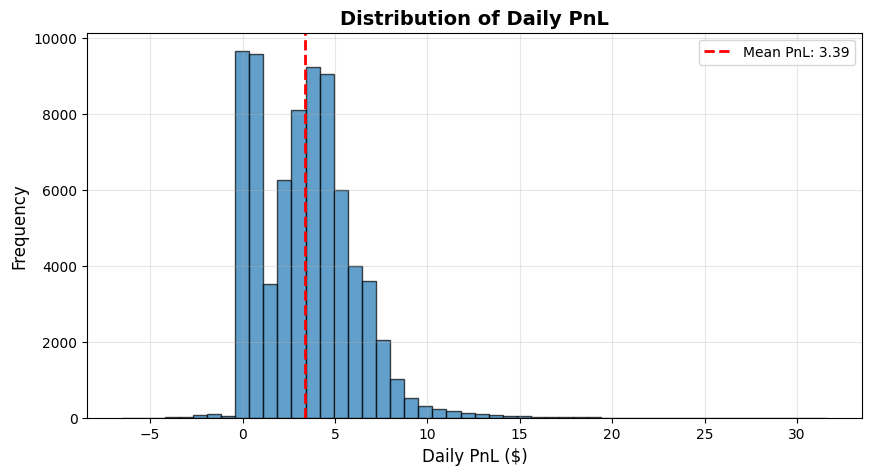

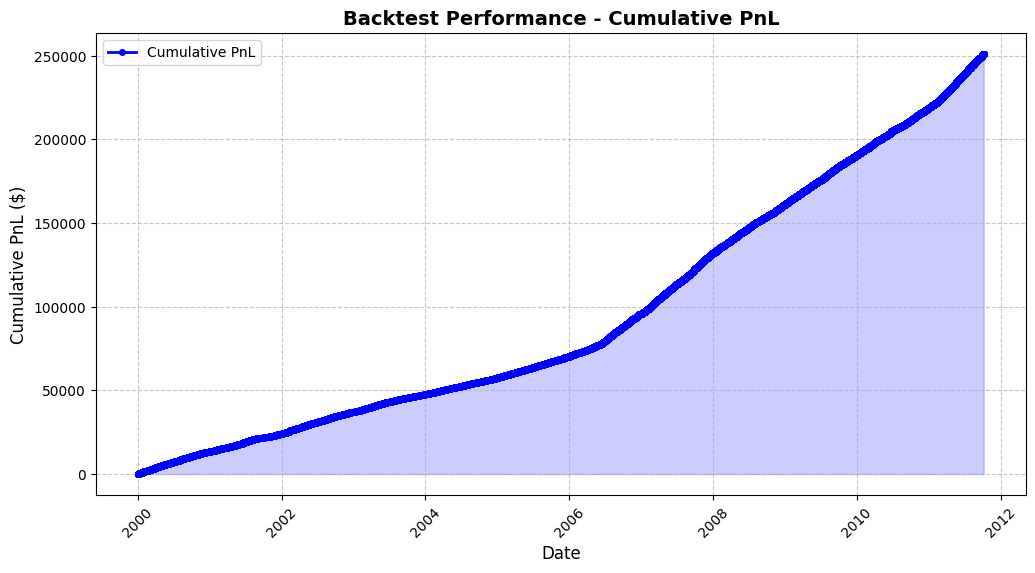

In [17]:
def backtest_strategy(df, strategy_fn, initial_capital=100):
    trades = strategy_fn(df)
    trades['cumulative_PnL'] = trades['PnL'].cumsum() + initial_capital

    if 'Date' in df.columns:
        trades['Date'] = df['Date'].iloc[:len(trades)]

    return trades


# Butterfly arbitrage strategy
def butterfly_arbitrage_strategy(df):
    arb_check = ArbitrageChecker(df)
    violations = arb_check.check_all_violations()
    butterfly_trades = pd.DataFrame(violations['butterfly'])

    if butterfly_trades.empty:
        return pd.DataFrame(columns=['Date', 'PnL'])

    butterfly_trades['PnL'] = np.sign(butterfly_trades['violation_size']) * np.abs(butterfly_trades['violation_size']) * 100

    if 'Date' in df.columns:
        butterfly_trades['Date'] = df['Date'].iloc[:len(butterfly_trades)]

    return butterfly_trades[['Date', 'PnL']]


# Delta monotonicity arbitrage strategy
def delta_monotonicity_strategy(df):
    arb_check = ArbitrageChecker(df)
    violations = arb_check.check_all_violations()
    delta_trades = pd.DataFrame(violations['monotonicity_delta'])

    if delta_trades.empty:
        return pd.DataFrame(columns=['Date', 'PnL'])

    delta_trades['PnL'] = np.sign(delta_trades['vol2'] - delta_trades['vol1']) * np.abs(delta_trades['vol2'] - delta_trades['vol1']) * 100

    if 'Date' in df.columns:
        delta_trades['Date'] = df['Date'].iloc[:len(delta_trades)]

    return delta_trades[['Date', 'PnL']]


# Combined strategy execution
def combined_strategy(df):
    butterfly_results = butterfly_arbitrage_strategy(df)
    delta_results = delta_monotonicity_strategy(df)

    # Merge both strategies' trades and sort by Date
    combined_results = pd.concat([butterfly_results, delta_results]).sort_values(by="Date").reset_index(drop=True)

    return combined_results

# Print final cumulative PnL
results = backtest_strategy(df, combined_strategy)
final_pnl = results["cumulative_PnL"].iloc[-1]
print(f"\nFinal Cumulative PnL: ${final_pnl:.2f}")

def plot_backtest_results(results):
    plt.figure(figsize=(12, 6))
    plt.plot(results["Date"], results["cumulative_PnL"], label="Cumulative PnL", color='b', linewidth=2, marker='o', markersize=4)

    plt.fill_between(results["Date"], results["cumulative_PnL"], alpha=0.2, color='blue')

    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Cumulative PnL ($)", fontsize=12)
    plt.title("Backtest Performance - Cumulative PnL", fontsize=14, fontweight='bold')

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    plt.xticks(rotation=45)

    plt.show()

def plot_pnl_distribution(results):
    plt.figure(figsize=(10, 5))
    plt.hist(results["PnL"], bins=50, edgecolor="black", alpha=0.7)

    plt.axvline(results["PnL"].mean(), color='red', linestyle='dashed', linewidth=2, label=f"Mean PnL: {results['PnL'].mean():.2f}")

    plt.xlabel("Daily PnL ($)", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.title("Distribution of Daily PnL", fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(alpha=0.3)

    plt.show()

plot_pnl_distribution(results)
plot_backtest_results(results)

# CONCLUSIONS

The dataset provides some arbitrage opportunities mainly connected to some discrepancies between the interpolated volatility and the actual one. By checking the associated paper of the student this may due to the fact that the volatility is not the realized one for every contract, but the interpolated one. This may explain why there are such opportunities and that the interpolated one may be incorrect due to numerical approximation.